# drifter single track rewrite: filter and segment division

In [1]:
import os
from glob import glob
import pickle

import dask
import dask.bag as db
import dask.dataframe as dd
import dask.array as da
from dask import delayed
from dask.distributed import Client, futures_of, as_completed
import xarray as xr
import pandas as pd
import geopandas
import numpy as np
import datetime

from scipy import signal
import scipy.ndimage as im

from matplotlib import pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.drifters as edr
import mitequinox.sigp as sigp

data_dir = '/work/ALT/swot/aval/syn/drifters/'

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster(cores=6, walltime='12:00:00', memory='20GB')
#cluster = PBSCluster(cores=1, walltime='01:00:00', memory='10GB')
#w = cluster.scale(40)
w = cluster.scale(10) # postprocessing

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask_jobqueue/config.py:12: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/deploy/local.py:138: UserWarning: diagnostics_port has been deprecated. Please use `dashboard_address=` instead
  "diagnostics_port has been deprecated. "


In [3]:
# get dask handles and check dask server status
#from dask.distributed import Client
client = Client(cluster)
#client = Client()

In [4]:
#client
cluster

In [11]:
#client.close()
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client


---
## load single trajectories

In [5]:
files = sorted(glob(data_dir+'single/*.p'))
#files = files[:500]
print('%d single trajectories' %len(files))

b = ( db.from_sequence(files[:], npartitions=100) \
              .map(lambda f: pickle.load(open(f, 'rb'))) )

12287 single trajectories


---

### utils

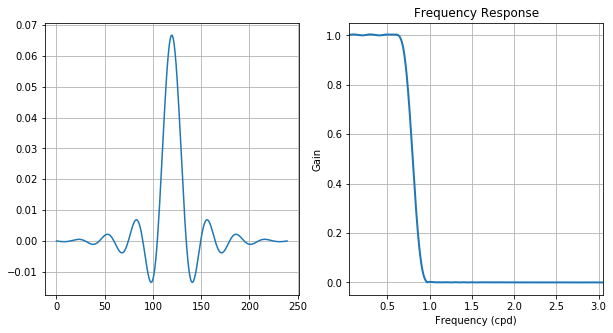

In [6]:
# low pass filter
h = sigp.gen_filter('subdiurnal', numtaps=24*10)
hh, f = sigp.filter_response(h, dt=1.)

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax.plot(h)
ax.grid()

ax = fig.add_subplot(122)
ax.plot(f, abs(hh), linewidth=2)
ax.set_xlabel('Frequency (cpd)')
ax.set_ylabel('Gain')
ax.set_title('Frequency Response')
ax.set_ylim(-0.05, 1.05)
ax.set_xlim(0.05, 3.05)
ax.grid(True)

In [7]:
def low_pass(x, hilbert=False):
    x_f = im.convolve1d(x, h, axis=0, mode='reflect')
    if hilbert:
        return signal.hilbert(x_f)
    else:
        return x_f

---

### core filtering code

In [8]:
filters = {'low': low_pass, 'inertial': None}
# could add tidal filters

In [17]:
def filter_break(p, T, filters, overlap, gd_threshold=.9):
    ID = p[1]
    dt = datetime.timedelta(T)
    _drop_col = ['GAP','RMSGAP']
    p0 = p[0].drop(columns=_drop_col)
    tmin, tmax = p0.index[0], p0.index[-1]
    t=tmin
    # for position filtering
    p0 = edr.compute_vector(p0)
    # interpolate small gaps
    p0 = p0[~pd.isnull(p0.index)].resample('H').interpolate('linear', limit=24)
    p_filt = {}
    for band in filters:
        if band != 'inertial':
            _p0 = p0.apply(filters[band])
            # update coordinates
            _p0 = edr.compute_lonlat(_p0, dropv=False)
            # manually edit column names for filtered variables (join rsuffix)
            _p0.columns = [str(col) + '_'+band for col in _p0.columns]
            # store
            p_filt[band] = {'p': _p0}
    #
    flag=False
    out = []
    while t+dt<tmax:
        #
        # update inertial filtered data if necessary
        if 'inertial' in filters:
            p_mean = edr.compute_lonlat(p0[t:t+dt].mean(axis=0))
            h = sigp.gen_filter('inertial', numtaps=24*10, 
                                lat=max(5., np.abs(p_mean.LAT)),
                                domega=0.1/24.)
            _p0 = p0.apply(lambda x: im.convolve1d(x, h, axis=0, mode='constant'))
            _p0.columns = [str(col) + '_inertial' for col in _p0.columns]
            p_filt['inertial'] = {'p': _p0}
        # should not consider segments with not enough data points
        lp = p0.loc[t:t+dt]
        if (len(lp['LON'][lp['LON'].notnull()].index)>gd_threshold*T*24):
            # compute average position
            lp = p0.loc[t:t+dt]
            for band in filters:
                lp = lp.join(p_filt[band]['p'].loc[t:t+dt])
            out += [{'df': lp, 'ID': '%d'%(ID), 't0': t}]
        t+=dt*(1-overlap)
    if flag:
        out = None
    return out

In [18]:
out = filter_break(b.take(5)[-1], 30, filters, .5)

In [19]:
out[0]['df']

,LAT,LON,U,V,LAT_ERR,LON_ERR,U_ERR,V_ERR,DROGUE,v0,...,U_inertial,V_inertial,LAT_ERR_inertial,LON_ERR_inertial,U_ERR_inertial,V_ERR_inertial,DROGUE_inertial,v0_inertial,v1_inertial,v2_inertial
TIME,,,,,,,,,,,,,,,,,,,,,
2005-04-15 13:00:00,47.50113,309.98047,0.0065,-0.0099,0.00764,0.01800,0.0,0.0,1.0,0.434075,...,0.001766,0.014804,4.676308e-04,0.000878,0.0,0.0,0.019474,0.008436,-0.010070,0.014375
2005-04-15 14:00:00,47.50133,309.98109,0.0057,-0.0117,0.00594,0.01342,0.0,0.0,1.0,0.434079,...,0.002781,0.007649,4.258048e-04,0.001080,0.0,0.0,0.036015,0.015616,-0.018626,0.026577
2005-04-15 15:00:00,47.50158,309.98171,0.0044,-0.0149,0.00418,0.00874,0.0,0.0,1.0,0.434083,...,0.003418,-0.000793,3.193695e-04,0.001127,0.0,0.0,0.047240,0.020491,-0.024432,0.034855
2005-04-15 16:00:00,47.50193,309.98231,0.0025,-0.0231,0.00249,0.00393,0.0,0.0,1.0,0.434085,...,0.003569,-0.009273,1.632694e-04,0.001010,0.0,0.0,0.051503,0.022346,-0.026638,0.037996
2005-04-15 17:00:00,47.50122,309.98258,-0.0010,-0.0403,0.00096,0.00222,0.0,0.0,1.0,0.434094,...,0.003192,-0.016512,-1.974417e-05,0.000746,0.0,0.0,0.048201,0.020918,-0.024930,0.035556
2005-04-15 18:00:00,47.49942,309.97695,-0.1214,-0.0674,0.00031,0.00203,0.0,0.0,1.0,0.434058,...,0.002324,-0.021398,-2.024704e-04,0.000373,0.0,0.0,0.037858,0.016436,-0.019582,0.027922
2005-04-15 19:00:00,47.49727,309.97100,-0.1213,-0.0675,0.00024,0.00178,0.0,0.0,1.0,0.434022,...,0.001073,-0.023154,-3.573697e-04,-0.000054,0.0,0.0,0.022044,0.009578,-0.011403,0.016253
2005-04-15 20:00:00,47.49510,309.96518,-0.1214,-0.0675,0.00017,0.00174,0.0,0.0,1.0,0.433987,...,-0.000386,-0.021466,-4.607649e-04,-0.000473,0.0,0.0,0.003131,0.001374,-0.001622,0.002299
2005-04-15 21:00:00,47.49292,309.95948,-0.1217,-0.0675,0.00011,0.00189,0.0,0.0,1.0,0.433953,...,-0.001842,-0.016542,-4.964430e-04,-0.000823,0.0,0.0,-0.016067,-0.006956,0.008306,-0.011864


In [12]:
#list(df)

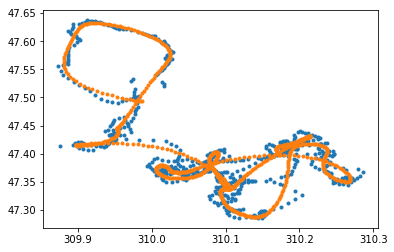

In [20]:
df = out[0]['df']
ax = plt.subplot(111)
ax.plot(df['LON'], df['LAT'],'.')
#ax.plot(df['LON_low'], df['LAT_low'],'.')
ax.plot(df['LON_low']+360., df['LAT_low'],'.')

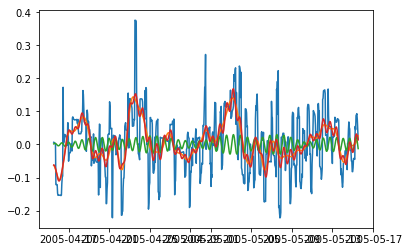

In [21]:
ax = plt.subplot(111)
ax.plot(df['U'])
ax.plot(df['U_low'])
ax.plot(df['U_inertial'])
ax.plot(df['U_low']+df['U_inertial'])

## store now

In [22]:
pref = 'low_inertial_'

In [24]:
Nmax=100

def store_partition(partition):
    buffer=[]
    idx=0
    gen = (rr for rr in partition if len(rr)>0)
    for rr in gen:
        r=rr[0]
        df = r['df']
        df.index = df.index - df.index[0]
        ds = df.to_xarray()
        ds['ID'] = r['ID']
        ds['ID'] = ds['ID'].astype(np.dtype('U20'))
        ds['t0'] = r['t0']
        buffer.append(ds)
        while len(buffer)>Nmax:
            ds_ct = xr.concat(buffer[:Nmax], 'index')
            ds_ct.to_netcdf(data_dir+'single_tfilt/'+pref+'%s.nc' %r['ID'],
                            mode='w', unlimited_dims='index', compute=True)
            buffer = buffer[Nmax:]
            idx+=1
    return [buffer, idx]

In [25]:
#del b, futures

In [26]:
b = b.map(filter_break, 30, filters, .5).map_partitions(store_partition).persist()
futures = futures_of(b)

In [27]:
buffer=[]
idx=0
files_store_partition=0
for future in as_completed(futures):
    #print('+++ next future')
    for out in future.result():
        if isinstance(out,int):
            #print('files stored in store_partition = %d'%out)
            files_store_partition+=out
        elif isinstance(out,list):
            #print('list len = %d'%len(out))
            buffer+=out
            while len(buffer)>Nmax:
                ds_ct = xr.concat(buffer[:Nmax], 'index')
                ds_ct.to_netcdf(data_dir+'single_tfilt/'+pref+'buffered_%04d.nc' %idx, mode='w')
                idx+=1
                buffer = buffer[Nmax:]
ds_ct = xr.concat(buffer[:Nmax], 'index')
ds_ct.to_netcdf(data_dir+'single_tfilt/'+pref+'buffered_%04d.nc' %idx, mode='w')
idx+=1

print('Number of files stored in store_partition = %d'%(files_store_partition*Nmax))
print('Number of files stored via buffer = %d'%idx)

Number of files stored in store_partition = 0
Number of files stored via buffer = 114


No files are stored in store_partition at the moment, you need to decrease the number of partitions or Nmax in order to store with workers

In [28]:
cluster.close()

---

In [ ]:
client.restart()

In [95]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
